<h1>"Deep Earth"</h1>
<h3> - An Exploration to GeoSpatial Imagery Classification Pipeline and Normalized Difference Vegetation Index ("NDVI")</h3>

<h2>Final Project of Deep Learning Foundation (ELEC ENG 435)</h2>
<h3>Group Member: Zhili Wang (solo) </h3>

<h1>Presentation Youtube Link</h1>

https://www.youtube.com/channel/UCG5Rx8GLhQDCmeCYK0CHSQA/videos?view_as=subscriber

<h1>Structure</h1>
Due to a lack of GPU hardware or a premium Google-drive account (I have to utilize Colab's free GPU access, but the data for this project exceeded a free Google-drive account's 15-GB limit), I have to run my code on 2 different platforms:

  - [MUST RAN AT LOCAL ONLY] Convert datasets to a .npz file with numpy.savez_compress() function 
  - Brief EDA
  - Demonstrating a few NDVI samples
  - Defining, fitting, and testing image classification CNN models: baseline + VGG-16
  - Model improvements: dropout regularization, image augmenting and tuning
  - Model selection and prediction

<h1> Main Objectives </h1>

Preparing for Professor Katsaggelos' geospatial research regarding change of environemnt, such as declining in urban vegetation covers and deforestations. I would also like to turn this into a GeoSpatial image processing pipeline.

<h3>Specific tasks of this project includes:</h3>

- Familiarizing myself with the pipeline of preprocessing satellite imagery and EDA 
- Understanding NVDI concepts and perform relevant basic analysis
- Exploring performances of Convolutional Neural Network models and transfer learning in image classifications
- Testing as many model improvement techniques as possible


<h1>Statement of Purpose / Changing Topic:</h1>

After attending one of Professor Katsaggelos' weekly meeting, I have been inspired by his idea of applying deep learning concepts on earth science topics via GeoSpatial imagery. In order to prepare for such a challenging committment, I must familiarize myself with image processing techniques, using a GeoSpatial dataset.

<h1> Source of Data </h1>

Satelitte imagery of the Amazon Rainforest and its description from a past 2017 Kaggle competition:
    
https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

Note: Under time-restriction and some unsolvable system errors, I was not able to deploy a third party satelitte image extraction pipeline (e.g. Google Earth API) to customize location of our data to an urban environment in the United States, after several failed attempts.

<h1>Difficulties Encountered</h1>

* Lack of powerful hardwares such as a tangible GPU, which caused less epochs, longer training time and countless crashes.
* Debugging/fixes due to recent TensorFlow and Keras update, will focus more on PyTorch
* Dealing with high-resolutin images

<h1>References</h1>

<h3>I would like to thank and give credits to the following sources:</h3>

* "Deep Learning" by Ian Goodfellow, Yoshua Bengio and Aaron Courville

* "ImageNet Classification with Deep Convolutional Neural Networks" by Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton:
http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf

* "The 4 Convolutional Neural Network Models That Can Classify Your Fashion Images" by James Le
https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

* "Why You Should Start Using .npy File More Often" by Tirthajyoti Sarkar
https://towardsdatascience.com/why-you-should-start-using-npy-file-more-often-df2a13cc0161


<h2>Google drive must be mounted when running any modelling-relevant code</h2>

In [221]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Get label classes
from itertools import chain
import seaborn as sns
# data conversion
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# general
import numpy as np
import pandas as pd
import keras
import sys
import os
import gc
# from PIL import Image
import matplotlib.pyplot as plt 
# from pandas import read_csv
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras import backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#!pip install -U -q tifffile
import tifffile
from skimage import io

from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras.models import load_model

In [142]:
'''
# disabled tensorflow deprecation warnings, but doesn't seem to work in TF 2.1
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# expand colab cell width
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))
'''

'\n# disabled tensorflow deprecation warnings, but doesn\'t seem to work in TF 2.1\nfrom tensorflow.python.util import deprecation as deprecation\ndeprecation._PRINT_DEPRECATION_WARNINGS = False\n\n# expand colab cell width\nfrom IPython.core.display import display, HTML \ndisplay(HTML("<style>.container { width:100% !important; }</style>"))\n'

<h2>Simple EDA</h2>

Data includes: jpg images, tif images, csv file


In [223]:
# map_csv = read_csv('/Users/zhiliwang/Documents/nu_dl/forest/data/train_v2.csv')
map_csv = pd.read_csv('/content/drive/My Drive/dl_final_data/train_v2.csv')
print("There are {} images, and {} columns in the label file.".format(map_csv.shape[0], map_csv.shape[1]))
print(map_csv.head())
print('-' * 60)
print(map_csv.tail())

There are 40479 images, and 2 columns in the label file.
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
------------------------------------------------------------
        image_name                                           tags
40474  train_40474                                  clear primary
40475  train_40475                                         cloudy
40476  train_40476                      agriculture clear primary
40477  train_40477                 agriculture clear primary road
40478  train_40478  agriculture cultivation partly_cloudy primary


In [224]:
# labels_df = pd.read_csv('/Users/zhiliwang/Documents/nu_dl/forest/data/train_v2.csv')
labels_df = pd.read_csv('/content/drive/My Drive/dl_final_data/train_v2.csv')
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
num_labels = len(labels_list)
uniq_labels = set(labels_list) 
num_uniq_labels = len(uniq_labels) 
print("There are {} labels in the training set".format(num_labels))
print("They are distributed among the {} following classes:".format(num_uniq_labels))
print(uniq_labels)

There are 116278 labels in the training set
They are distributed among the 17 following classes:
{'primary', 'habitation', 'partly_cloudy', 'road', 'artisinal_mine', 'agriculture', 'selective_logging', 'cultivation', 'haze', 'bare_ground', 'blooming', 'blow_down', 'cloudy', 'clear', 'conventional_mine', 'water', 'slash_burn'}


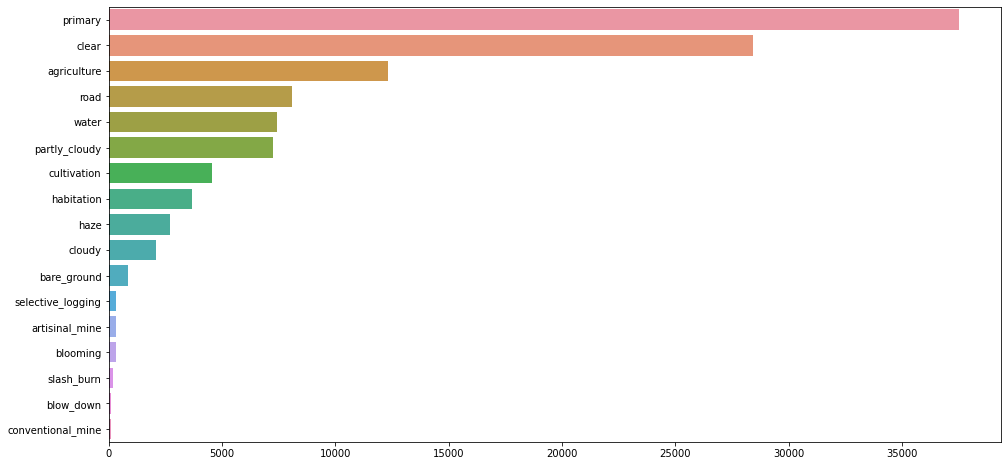

In [225]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()

<h3>All images below all titled with their labels</h3>

* Should demo this locally as google-drive has a size limit for data
* The specific design of this automatic-mechanic does not allow me to "sample" a few images to demo on colab

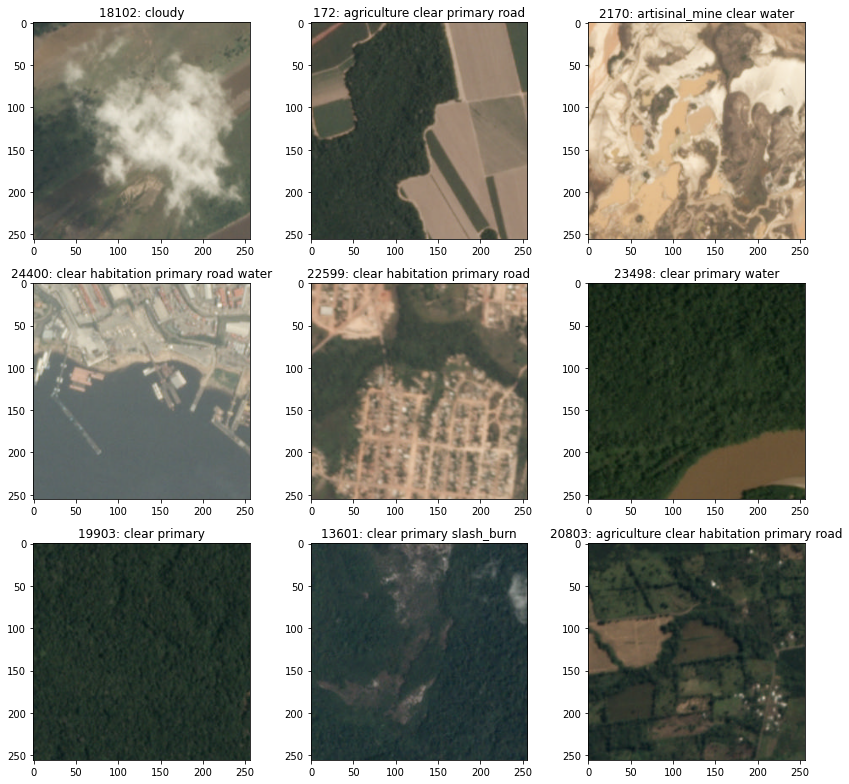

In [226]:
select = [18102, 172, 2170, 24400, 22599, 23498, 19903, 13601, 20803]
imgs_ls = []
for ind in select:
    temp_path = '/content/drive/My Drive/dl_final_data/train-jpg/train_{}.jpg'\
                .format(str(ind))
    imgs_ls.append(temp_path)

plt.figure(figsize=(12,11))
for j in range(9): 
    plt.subplot(3, 3, j + 1)
    plt.imshow(plt.imread(imgs_ls[j]))
    plt.title("{}: {}".format(select[j], map_csv['tags'][select[j]]))
    plt.tight_layout()
plt.show()

<h3>Demo: Manually Inputting Image Path</h3>

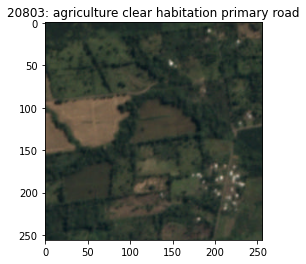

In [194]:
manual_path = '/content/drive/My Drive/dl_final_data/train-jpg/train_20803.jpg'
dex = manual_path.split("train_")[1].split('.')[0]
plt.imshow(plt.imread(manual_path))
plt.title("{}: {}".format(dex, map_csv['tags'][int(dex)]))
plt.show()

<h1>NDVI</h1>

* This part can only done with a .tif file, which is an image file saved in a high-quality graphics format
* The higher the NDVI, the stronger and healthier the vegetation cover is
* Strong-weak descent is by default presented in Red-Green-Blue order: the more "red" parts there are, the healthier and stronger the vegetation cover is
* Should demo this locally as google-drive has a size limit for data
* The specific design of this automatic-mechanic does not allow me to "sample" a few images to demo on colab

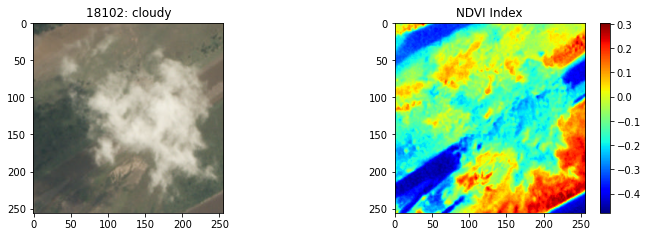

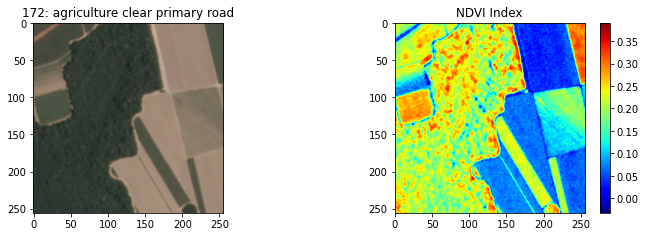

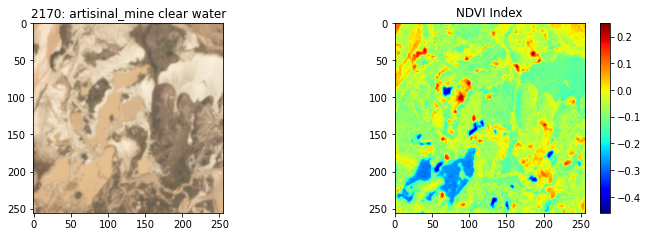

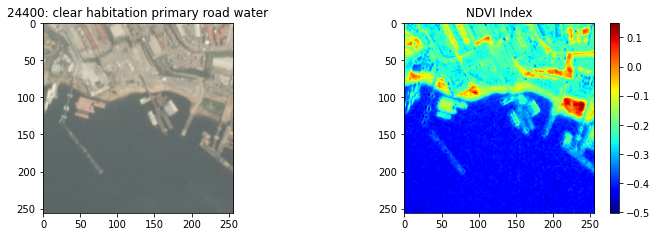

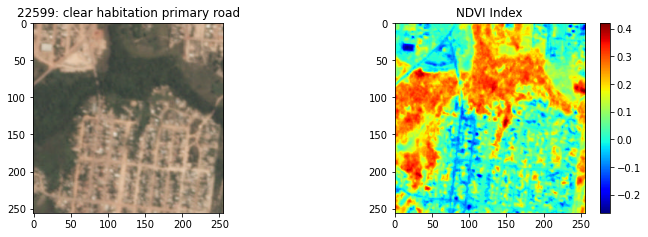

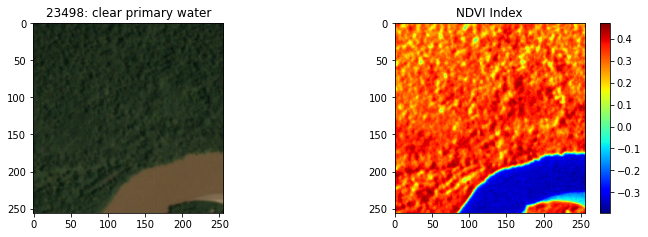

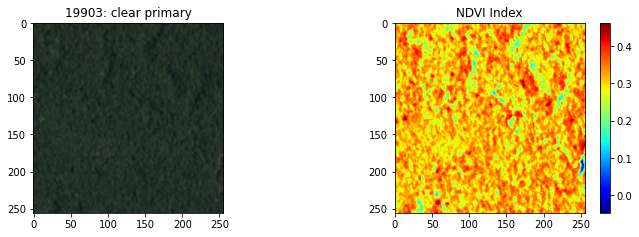

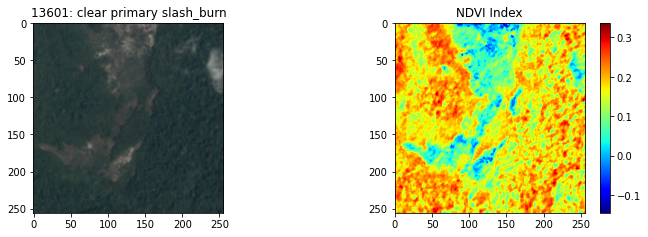

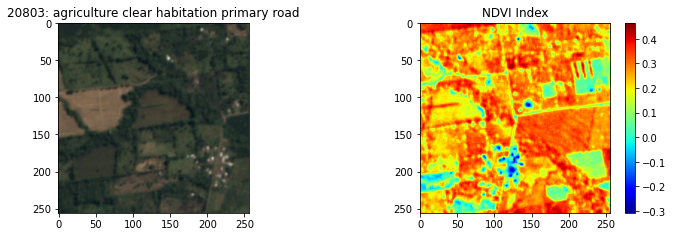

In [195]:
# !pip install -U -q tifffile
# import tifffile
# from skimage import io

select = [18102, 172, 2170, 24400, 22599, 23498, 19903, 13601, 20803]
tifs_ls = []
for ind in select:
    temp_path = '/content/drive/My Drive/dl_final_data/train-tif-v2/train_{}.tif'\
                .format(str(ind))
    tifs_ls.append(temp_path)

# Calculate NDVI
imgs = [io.imread(path) / io.imread(path).max() for path in tifs_ls]
ndvis = [(img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) for img in imgs]

for m in range(9):
    # img_id = m
    plt.figure(figsize=(12,3.5))
    plt.subplot(121)
    temp = select[m]
    plt.title("{}: {}".format(select[m], map_csv['tags'][temp]))
    plt.imshow(plt.imread(imgs_ls[m]))
    plt.subplot(122)
    plt.title('NDVI Index')
    plt.imshow(ndvis[m], cmap='jet')
    plt.colorbar()
    plt.show()

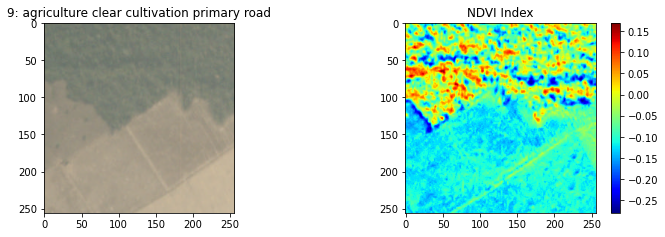

In [196]:
share_dex = "9" # we only uploaded 1-9 and 18102, 172, 2170, 24400, 22599, 23498, 19903, 13601, 20803
man_tif_path = '/content/drive/My Drive/dl_final_data/train-tif-v2/train_{}.tif'.format(share_dex)
manual_path = '/content/drive/My Drive/dl_final_data/train-jpg/train_{}.jpg'.format(share_dex)
img = io.imread(man_tif_path) / io.imread(man_tif_path).max() 
ndvis = (img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) 

man_tif_dex = man_tif_path.split("train_")[1].split('.')[0]
plt.figure(figsize=(12,3.5))
plt.subplot(121)
dex = manual_path.split("train_")[1].split('.')[0]
plt.imshow(plt.imread(manual_path))
plt.title("{}: {}".format(dex, map_csv['tags'][int(dex)]))

plt.subplot(122)
plt.title('NDVI Index')
plt.imshow(ndvis, cmap='jet')
plt.colorbar()
plt.show()

<h3>NVDI is extremely convenient, but it can use further processing to remove the noise:</h3>

* noise such as cloud and fog/haze blocks some of the vegetation cover, which yield inaccurate indices
* limited by the techniques I am deploying, NDVI cannot tell the difference between natural and "artificial" vegetations. For examples, for a environment-protecting-related research, we do not want to include human-made croplands and golf courts as a part of vegetation cover

<h3>Scalability Among Platforms: Encode and Convert Data Files to A Numpy In-Memory .NPZ File </h3>

In [0]:
# load tag csv file and map them to integers
def create_tag_map(map_csv):
    labels = set()
    for i in range(len(map_csv)):
        # process spaced-separated terms into a one-term label
        tags = map_csv['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    labels = list(labels)
    labels.sort()
    # turn maps to dictionaries and reverse keys and values
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {j:labels[j] for j in range(len(labels))}
    return labels_map, inv_labels_map

In [0]:
# create a mapping of filename to a list of tags
def create_file_map(map_csv):
    mapping = dict()
    for i in range(len(map_csv)):
        name, tags = map_csv['image_name'][i], map_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

In [0]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    encoding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [0]:
# load all images into memory to turn it to a Numpy .npz file
def load_data_convert(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    for filename in listdir(folder):
        photo = load_img(path + filename, target_size=(128, 128))
        # convert to numpy array and get tagged
        photo = img_to_array(photo, dtype = 'uint8')
        tags = file_mapping[filename[:-4]]
        # one hot encoding tags
        target = one_hot_encode(tags, tag_mapping)
        photos.append(photo)
        targets.append(target)
    x = np.asarray(photos, dtype = 'uint8')
    y = np.asarray(targets, dtype = 'uint8')
    return x, y

In [231]:
#map_csv = pd.read_csv('/Users/zhiliwang/Documents/nu_dl/forest/data/train_v2.csv')
#map_csv = pd.read_csv('/content/drive/My Drive/dl_final_data/train_v2.csv')
# map tags to integers, filenmae to tags
tag_mapping, _ = create_tag_map(map_csv)
file_map = create_file_map(map_csv)
print(tag_mapping)

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


<h3>This cell has to be done locally as google drive has a size limit:

In [0]:
# save both arrays to one file in numpy compressed format
# csv --> ndarray
a standard binary file format for persisting a single arbitrary NumPy array on disk
folder = '/Users/zhiliwang/Documents/nu_dl/forest/data/train-jpg/'
x, y = load_data_convert(folder, file_map, tag_mapping)
print(x.shape, y.shape)
np.savez_compressed('amazon.npz', x, y)
print("Compression done and the npz file is created.")

(40479, 128, 128, 3) (40479, 17)
Compression done and the npz file is created.


<h2>From here we need PyDrive must train, test and save models within Google Colab (Colab cannot access or save files locally)

In [0]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

<h1>Modelling</h1>
20 epochs are the max I can do with my equipment and Colab without crashing

In [0]:
# load_data, f-beta, and plot functions stay identical
def load_dataset():
    # if loading locally: data = np.load('/Users/zhiliwang/Documents/nu_dl/forest/amazon.npz')
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz') 
    x, y = data['arr_0'], data['arr_1']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

<h3>$F_\beta=(1+\beta^2)\cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision)+recall}$</h3>

<h3>I want a stronger emphasis on recall, therefore I set beta to 2 (F2 Score).</h3>

In [0]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # remove predictions
    y_pred = backend.clip(y_pred, 0, 1)
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis = 1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis = 1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis = 1)
    # precision (pr) and recall (re)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    fbeta_score = backend.mean((1 + beta ** 2) * (p * r) / ((beta ** 2) * p + r + backend.epsilon()))
    return fbeta_score

<h3> Plot learning curves using corss entropy losses and F2 as metrics. </h3>

In [0]:
# plot diagnostic learning curves
def plot_diag(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('F-Beta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='red', label='test')
    plt.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 2.1, wspace = 0.2, hspace = 0.2)
    plt.show()

Comparing the 3 common activation functions:

<h3>$Sigmoid(x) = \frac{1}{1 + e^-x}$</h3>

<h3>$Tanh(x) = \frac{2}{1 + e^-2x} - 1$</h3>

<h3>$ReLu(x) = max(0, x)$</h3>

<h3>We will use rectified linear unit a.k.a. ReLu as our primary activation function for this project, due to the following reason:</h3> 

* ReLu is simpler. In order to save computational power for more epochs with the hardware I have, I want to avoid using activation methods that is likely turning to a vanishing-gradient problem, such as Sigmoid.

* According to the ImageNet Classification paper by Dr. Alex Krizhevsky, ReLu has a better convergence performance in practitioning tasks. 

* A lot of large-scale satellite-imagery projects use ReLu as activation function. With my past experience, I don't think this particular dataset would cause a dying-out issue (output of first layer close or equal to zero), while Sigmoid has a good chance to blowing up the activation. This is a risk that I am willing to take.

In [0]:
# define cnn model
def cnn_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# test, evaluate, and potentially save model
def test_cnn():
    train_X, train_y, test_x, test_y = load_dataset()
    # data generator and train/test iterators
    datagen = ImageDataGenerator(rescale = 1.0/255.0)
    train_iter = datagen.flow(train_X, train_y, batch_size = 128)
    test_iter = datagen.flow(test_x, test_y, batch_size = 128)
    # define and fit model
    model = cnn_model()
    history = model.fit_generator(train_iter, steps_per_epoch = len(train_iter),
              validation_data = test_iter, validation_steps = len(test_iter), epochs = 20, verbose = 0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_iter, steps = len(test_iter), verbose = 0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss=0.145, F-Beta=0.831


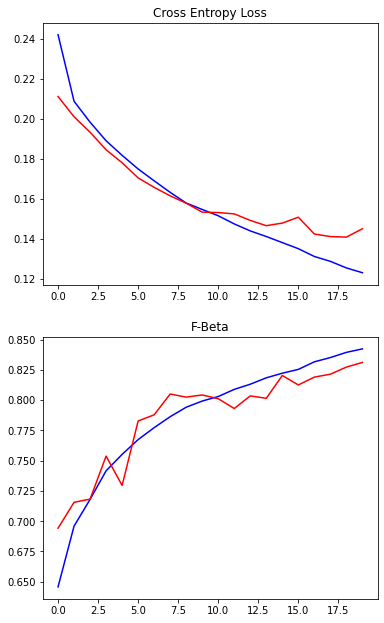

In [0]:
# entry point, run the test harness
test_cnn()

<h3> A 83.10% accuracy is not too bad, but it is showing an overfitting tendency after the 13th epoch. This can be dealt with techniques of adding dropout regularization and image augmentations.</h3>

<h1> Adding Dropout For Overfitting </h1>







Due to my concern for overfitting tendency, I add a 20% dropout regularization to each CNN block and a 50% dropout to a fully connected layers when it performs classifications.

In [0]:
# improving model and reducing overfit with dropout:
# almost identical definition with baseline model but adding dropout 
# from keras.layers import Dropout

def cnn_model_dropout(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) # dropout 20% nodes
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) # dropout 20% nodes
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) # dropout 20% nodes
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5)) # drop 50% fully connected layers
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [0]:
# test model and potentially save it to google drive
def test_cnn_dropout():
    # load dataset
    train_X, train_y, test_x, test_y = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # iterators
    train_iter = datagen.flow(train_X, train_y, batch_size=128)
    test_iter = datagen.flow(test_x, test_y, batch_size=128)
    # define and fit model
    model = cnn_model_dropout()
    history = model.fit_generator(train_iter, steps_per_epoch=len(train_iter),
              validation_data=test_iter, validation_steps=len(test_iter), epochs=20, verbose=0)
    # evaluate
    loss, fbeta = model.evaluate_generator(test_iter, steps=len(test_iter), verbose=0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # print learning curves
    plot_diag(history)

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)

Loss=0.153, F-Beta=0.804


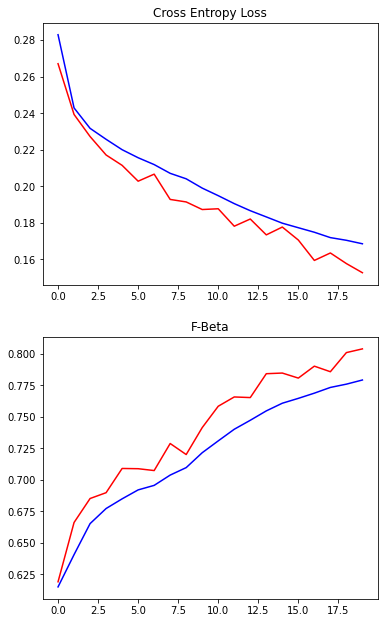

In [0]:
test_cnn_dropout()

<h1> Image Data Augmentation </h1>


We got a lower accuracy of 80.4% from the model above, but fix the tendency of overfitting.

There are 28,335 images in the training data, which may not be enough to get a good model.

I think it's a good idea here to flip and rotate the images to create modified datasets to expand our training set. Even though this creates some more noise, but won't discourage the model to learn the same image features.



In [0]:
# image data augmentation
# control variates: using the original cnn
def cnn_model_aug(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

<h3>Difficulty that cost me almost a day to fix: I made a mistake for saving these models for demo, which I will explain later.</h3>

In [0]:
# test and potentially save model to g-drive
def test_cnn_aug():
    train_X, train_y, test_x, test_y = load_dataset()
    # adding flips, everthing else stay the same:
    # data generator and train/test iterators
    train_datagen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
    train_iter = train_datagen.flow(train_X, train_y, batch_size = 128)
    test_iter = test_datagen.flow(test_x, test_y, batch_size = 128)
    # model definition and fitting
    model = cnn_model_aug()
    history = model.fit_generator(train_iter, steps_per_epoch=len(train_iter),
              validation_data=test_iter, validation_steps=len(test_iter), epochs = 20, verbose = 0)
    # model evaluation
    loss, fbeta = model.evaluate_generator(test_iter, steps = len(test_iter), verbose = 0)
    print('Loss=%.3f, F-Beta=%.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)
    
    # save model to g-drive
    model.save('model_base_aug.h5')
    model_file = drive.CreateFile({'title' : 'model_base_aug.h5'})  
    model_file.SetContentFile('model_base_aug.h5')                       
    model_file.Upload() 
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss=0.140, F-Beta=0.811


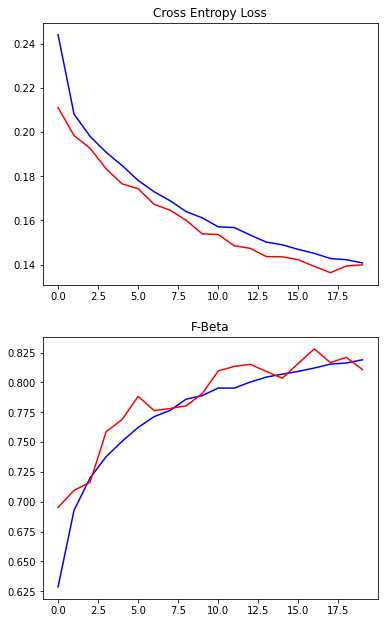

Model is saved.
Model downloaded to google drive.


In [0]:
test_cnn_aug()

<h1>VGG-16 Model</h1> 

Rationale:

* A good ImageNet CNN vision model architecture.  
* Has convolution layers of 3x3 filter with a stride 1 
* Great Control variate for this project: Consistent convolution architecture and max pool layers: always has the same padding and maxpool layer of a (2x2) filter of stride 2.
* 16 layers with weights and two fully connected layers at the end of the model followed by a softmax output. 
* Not as many hyperparameters

<h3>Tuning the model by enabling last block of every layer to be trainable.</h3>

In [0]:
#from keras.applications.vgg16 import VGG16

def vgg16_model(in_shape=(128, 128, 3), out_shape=17):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # tuning
    for layer in model.layers:
        layer.trainable = False
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile with optimizer
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

We need to know ImageNet's data-generator's mean pixel intensity for RGB coloring to center the intensities at 0, which would improve training efficiencies. 
Researchers and engineers acknowledged the set of values fixed at [103.989, 116.779, 123.68] or the inverse. I am not sure if it has anything to do with the data augmentation.

In [0]:
def test_vgg_aug():
    train_x, train_y, test_x, test_y = load_dataset()
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center = True, horizontal_flip = True, \
                                       vertical_flip = True, rotation_range = 90)
    test_datagen = ImageDataGenerator(featurewise_center = True)
    # flip image-net mean pixel intensity for RGB values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # iterators
    train_iter = train_datagen.flow(train_x, train_y, batch_size=128)
    test_iter = test_datagen.flow(test_x, test_y, batch_size=128)
    # define and fit model
    model = vgg16_model()
    history = model.fit_generator(train_iter, steps_per_epoch=len(train_iter),
              validation_data=test_iter, validation_steps=len(test_iter), epochs=20, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_iter, steps=len(test_iter), verbose=0)
    print('Loss = %.3f, F-Beta = %.3f' % (loss, fbeta))
    # learning curves
    plot_diag(history)

    # save model
    model.save('model.h5')
    model_file = drive.CreateFile({'title' : 'model.h5'})
    model_file.SetContentFile('model.h5')
    model_file.Upload()
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")
    
    # only if you want to access that model right away:
    # file_obj = drive.CreaeFile({'id': 'get-id'})                       
    # file_obj.GetContentFile('model.h5')

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)














Loss = 0.095, F-Beta = 0.894


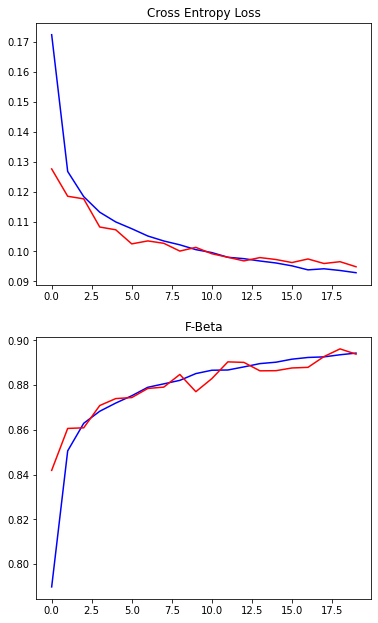

Model is saved.
Model downloaded to google drive.


In [0]:
test_vgg_aug()

<h3>I am satisfied and pleasantly surprised by how well image augmentation performs, in terms of both accuracies and reducing overfitting. Since this tuned-augmented-VGG model has a higher accuracy than the augmented-baseline-CNN model without an overfitting tendency. I saved this model for prediction for predicion.</h3>

<h1>Prediction</h1>
<h3>Quick Recap of Our Models and Performances:</h3>

| Model | Loss | F2 Score | Over- or Under-fit Tendency
|:-:|---|---|---|
| Baseline CNN  | 0.145  |  0.831 | Over
| Baseline with Dropout | 0.153 | 0.804 | Under
| Baseline with Augmentation | 0.140 | 0.811 | Unclear
| Tuned VGG-16 with Augmentation | 0.095 | 0.894 | Unclear

* For current research, we settle for tunned VGG-16 since it has the highest F2 score, the least loss, and not showing signs of over- or underfit (by 20 epochs)

<h3>Put the 30% tagged test-set data to train a new model for prediction</h3>

In [0]:
def load_dataset_pred():
    data = np.load('/content/drive/My Drive/dl_final_data/amazon.npz')
    x, y = data['arr_0'], data['arr_1']
    return x, y

In [0]:
# define model for prediction
def vgg16_model_pred(in_shape=(128, 128, 3), out_shape=17):
    model = VGG16(include_top=False, input_shape=in_shape)
    # tuning
    for layer in model.layers:
      layer.trainable = False
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define, compile with optimizer
    model = Model(inputs = model.inputs, outputs = output)
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    return model

In [0]:
#from keras.applications.vgg16 import VGG16

# same as vgg16 above, just training set, no diagnosis plot
def final_model():
    x, y = load_dataset_pred()
    datagen = ImageDataGenerator(featurewise_center = True, horizontal_flip = True, \
                                 vertical_flip = True, rotation_range = 90)  
    datagen.mean = [123.68, 116.779, 103.939]
    train_iter = datagen.flow(x, y, batch_size=128)
    # define and fit
    model = vgg16_model_pred()
    model.fit_generator(train_iter, steps_per_epoch = len(train_iter), epochs = 20, verbose = 1)

    # save model on google drive
    model.save('final_model.h5')
    model_file = drive.CreateFile({'title' : 'final_model.h5'})
    model_file.SetContentFile('final_model.h5')
    model_file.Upload()
    print("Model is saved.")
    # download to google drive                       
    drive.CreateFile({'id': model_file.get('id')})
    print("Model downloaded to google drive.")

In [0]:
final_model()





58892288/58889256 [==============================] - 1s 0us/step








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
317/317 [==============================] - 155s 490ms/step - loss: 0.1755
Epoch 2/20
317/317 [==============================] - 152s 479ms/step - loss: 0.1241
Epoch 3/20
317/317 [==============================] - 151s 477ms/step - loss: 0.1143
Epoch 4/20
317/317 [==============================] - 152s 478ms/step - loss: 0.1094
Epoch 5/20
317/317 [==============================] - 151s 477ms/step - loss: 0.1059
Epoch 6/20
317/317 [==============================] - 152s 478ms/step - loss: 0.1040
Epoch 7/20
317/317 [==============================] - 152s 478ms/step - loss: 0.1020
Epoch 8/20
317/317 [==============================] - 151s 476ms/step - loss: 0.1003
Epoch 9/20
317/317 [==============================] - 152s 479ms/step - loss: 0.0991
Epoch 10/20
317/317 [==============================] - 153s 48

In [0]:
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(128, 128))
    # convert to array and reshape with 3 channels
    img = img_to_array(img)
    img = img.reshape(1, 128, 128, 3)
    # center pixel data for efficiency as we mentioned
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [0]:
# convert a prediction to tags
def prediction_to_tags(inv_mapping, prediction):
    # prob dist: {0, 1}
    values = prediction.round()
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

<h3>Get prediction: </h3>

In [249]:
#from keras.models import load_model
idex = input("Please input index of image that you would like to predict: ")
# local = pd.read_csv('/Users/zhiliwang/Documents/nu_dl/forest/data/train_v2.csv') 
mapping_csv = pd.read_csv('/content/drive/My Drive/dl_final_data/train_v2.csv')
img_path = '/content/drive/My Drive/dl_final_data/train-jpg/train_{}.jpg'.format(idex)
img = load_image(img_path)
model = load_model('/content/drive/My Drive/final_model.h5')
_, inv_mapping = create_tag_map(mapping_csv)
print(tag_mapping)
print(inv_mapping)
# f-beta score of prediction for each category
print(model.predict(img)[0])
# predicted tags
print("Model predicts the label(s) to be: {}"\
      .format(prediction_to_tags(inv_mapping, model.predict(img)[0])))
print("Actual label(s) of this image: {}".format(map_csv['tags'][int(idex)]))

Please input index of image that you would like to predict: 18102
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}
[9.0802968e-01 2.4240315e-03 3.7612528e-02 2.3415685e-04 2.6783347e-04
 1.6261071e-02 1.1492372e-03 2.0901442e-02 2.2176304e-01 6.1154604e-02
 8.9740753e-04 9.8500454e-01 9.8088324e-01 5.8285010e-01 3.3093393e-03
 5.8066547e-03 6.2267286e-01]
Model predicts the label(s) to be: ['agriculture', 'partly_cloudy', 'primary', 'road', 'water']
Actual label(s) o

<h3>This cell is identical with the one demo before, only for easy look-ups</h3>
<h3>Not enough space 

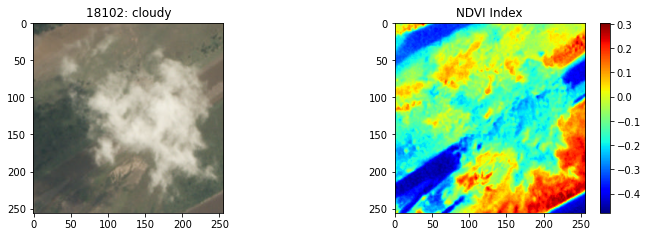

In [250]:
share_dex = "18102" # we only uploaded 1-9 and 18102, 172, 2170, 24400, 22599, 23498, 19903, 13601, 20803
man_tif_path = '/content/drive/My Drive/dl_final_data/train-tif-v2/train_{}.tif'.format(share_dex)
manual_path = '/content/drive/My Drive/dl_final_data/train-jpg/train_{}.jpg'.format(share_dex)
img = io.imread(man_tif_path) / io.imread(man_tif_path).max() 
ndvis = (img[:,:,3] - img[:,:,0])/((img[:,:,3] + img[:,:,0])) 

man_tif_dex = man_tif_path.split("train_")[1].split('.')[0]
plt.figure(figsize=(12,3.5))
plt.subplot(121)
dex = manual_path.split("train_")[1].split('.')[0]
plt.imshow(plt.imread(manual_path))
plt.title("{}: {}".format(dex, map_csv['tags'][int(dex)]))

plt.subplot(122)
plt.title('NDVI Index')
plt.imshow(ndvis, cmap='jet')
plt.colorbar()
plt.show()

<h1> Future Directions </h1>

* Access to a legitimate GPU to train all models via at least 200 epochs
* Investigate methods and API to access GeoSpatial imagery data with customized locations, such as urban areas of Chicago and the Silicon Valley
* Try to write a program to show ImageNet's mean pixel intensity values
* Fit this structured dataset to other "hot" models in the current industry, such as AlexNet
* Research how to deal with noise in satellite imagery (cloud, fog/haze, etc.)
* Research on a deeper level of classification over similar categories (e.g. natural vs artifical cover such as cropland and golf courts)